In [ ]:
# Bucket data in Mollweide projection

In [1]:
import os
import sys
cwd = os.getcwd()
sys.path.insert(0, '/astro/andrassy/notebooks/lib/lcse')
import rprofile as rprofile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors
from matplotlib.patches import Polygon
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib nbagg
from mpl_toolkits.basemap import Basemap

data_path = "/rpod2/PPM/RProfiles/AGBTP_M2.0Z1.e-5/F4"
#data_path = "/rpod2/PPM/RProfiles/O-shell-M25/D15"
#data_path = "/rpod2/PPM/RProfiles/O-shell-M25/D19/RProfile-01"
rp_set = rprofile.rprofile_set(data_path)

/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# This is a copy-pasted code from O-shell-M25_analysis/upper_boundary_ut_D15.ipynb.
# Yes, this is a bad practice, but I don't have time to put it into a library.

def analyse_dump(rp, r1, r2):
    '''
    This function analyses ray profiles of one dump and returns

    r, ut, dutdr, r_ub,

    where

    r: radius,
    ut: RMS tangential velocity profiles for all buckets (except the 0th),
    dutdr: radial gradient of ut for all buckets (except the 0th),
    r_ub: radius of the upper boundary as defined by the minimum in dutdr
          for all buckets  (except the 0th).
    
    Parameters:
    rp: radial profile
    r1: minimum radius for the search for r_ub
    r2: maximum radius for the search for r_ub
    '''
    n_buckets = rp.get('nbuckets')
    
    r = rp.get_table('y')
    dr = 0.5*(np.roll(r, -1) - np.roll(r, +1))
    
    idx1 = np.argmin(np.abs(r - r1))
    idx2 = np.argmin(np.abs(r - r2))
    
    ekt = rp.get_table('ekt')
    ut = ekt[0, :, 1:n_buckets+1]**0.5

    dut = 0.5*(np.roll(ut, -1, axis = 0) - np.roll(ut, +1, axis = 0))
    dutdr = np.transpose(np.array([dut[:, i]/dr for i in range(n_buckets)]))
    
    idx_min_dutdr = [idx1 + np.argmin(dutdr[idx1:idx2 + 1, i]) \
                     for i in range(n_buckets)]
    r_ub = np.zeros(n_buckets)

    for bucket in range(n_buckets):
        idx = idx_min_dutdr[bucket]
        r_min = r[idx] # 0th-order estimate

        # try to fit a parabola around r_min
        r_fit = r[idx-1:idx+2]
        dutdr_fit = dutdr[idx-1:idx+2, bucket]
        coefs = np.polyfit(r_fit, dutdr_fit, 2)
        
        # hopefully we can determine the position of the minimum from the fit
        if coefs[0] != 0:
            r_min = -coefs[1]/(2.*coefs[0])
            # go back to 0th order if something has gone awry with the fit
            if r_min < r[idx -1] or r_min > r[idx + 1]:
                r_min = r[idx]
        
        r_ub[bucket] = r_min
        
    return r, ut, dutdr, r_ub

In [9]:
def bucket_map(rprofile, quantity, limits = None, ticks = None, file_name = None, time = None):
    
    '''
    Plots a Mollweide projection of the rprofile object using the mpl_toolkits.basemap package
    
    Parameters:
    -----------
    rprofile: rprofile object
        rprofile dump used just for geometry
    quantity: array
        data to be passed into the projection
    limits: 2 index array
        cmap limits, scale the colormap for limit[0] =min to 
        limit[1] =max
    ticks: 
        passed into matplotlib.colors.ColorbarBase see ColourbarBase
    file_name: string
        file name: '/path/filename' to save the image as
    time: float
        time to display as the title
    
    '''
    q = quantity#rp.get_table(quantity)[0, :, :]
    #r = rp.get('y')
    #idx_r0 = np.argmin(np.abs(r - r0))
    
    corners = rprofile.get_corners()
    corners_per_bucket = corners.shape[1]
    n_buckets = corners.shape[2]
    points_per_side = 10
    points_per_bucket = corners_per_bucket*points_per_side

    x = np.zeros((n_buckets, points_per_bucket))
    y = np.zeros((n_buckets, points_per_bucket))
    z = np.zeros((n_buckets, points_per_bucket))
    t = np.linspace(1., 0., num = points_per_side)
    for i in range(n_buckets):
        for k in range(corners_per_bucket):
            idx_range = range(points_per_side*k, points_per_side*(k + 1))
            x[i, idx_range] = t*corners[0, k - 1, i] + (1. - t)*corners[0, k, i]
            y[i, idx_range] = t*corners[1, k - 1, i] + (1. - t)*corners[1, k, i]
            z[i, idx_range] = t*corners[2, k - 1, i] + (1. - t)*corners[2, k, i]

    radius = (x**2 + y**2 + z**2)**0.5
    phi = np.arctan2(y, x)
    theta = np.pi/2. - np.arccos(z/radius)

    eps = 1e-3
    for i in range(phi.shape[0]):
        for k in range(phi.shape[1] - 1):
            # if the vertex k is at one of the poles
            if (np.abs(theta[i, k] - 0.5*np.pi) < eps or
                np.abs(theta[i, k] + 0.5*np.pi) < eps):
                if (theta[i, k] == theta[i, k - 1] and
                    phi[i, k] == phi[i, k - 1]):
                    phi[i, k - 1] = phi[i, k - 2]
                    phi[i, k] = phi[i, k + 1]

    # A first estimate of how many rows will be needed. We need more
    # than n_buckets, because we have to slice the polygons that
    # lie at the boundaries of the plot.
    n_rows_est = int(np.round(1.25*n_buckets))
    phi2 = np.zeros((n_rows_est, points_per_bucket))
    theta2 = np.zeros((n_rows_est, points_per_bucket))
    value = np.zeros(n_rows_est)
    n_rows = 0
    for i in range(n_buckets):
        # Add more rows if necessary.
        if n_rows >= phi2.shape[0]:
            n_rows_add = int(np.round(0.25*phi2.shape[0]))
            phi2 = np.vstack((phi2, np.zeros((n_rows_add, points_per_bucket))))
            theta2 = np.vstack((theta2, np.zeros((n_rows_add, points_per_bucket))))
            value = np.append(value, np.zeros(n_rows_add))

        this_phi = np.copy(phi[i, :])
        this_theta = np.copy(theta[i, :])
        this_value = q[i]# np.log10(q[idx_r0, i])

        if not (np.min(this_phi) < -0.5*np.pi and np.max(this_phi) > 0.5*np.pi):
            # This polygon doesn't touch the boundaries of the plot. Original
            # coordinates can be used directly.
            phi2[n_rows, :] = this_phi
            theta2[n_rows, :] = this_theta
            value[n_rows] = this_value
            n_rows += 1
        else:
            # This polygon lies on the boundary of the plot. We have to slice into
            # two polygons -- one on the left side of the plot and on on the right.
            # First add the one on the right.
            this_phi2 = np.copy(this_phi)
            for k in range(points_per_bucket):
                if this_phi2[k] <= -0.:
                    this_phi2[k] = np.pi

            phi2[n_rows, :] = this_phi2
            theta2[n_rows, :] = this_theta
            value[n_rows] = this_value
            n_rows += 1

            # Now add the one on the left.
            this_phi2 = np.copy(this_phi)
            for k in range(points_per_bucket):
                if this_phi2[k] >= 0.:
                    this_phi2[k] = -np.pi

            phi2[n_rows, :] = this_phi2
            theta2[n_rows, :] = this_theta
            value[n_rows] = this_value
            n_rows += 1

    # Trim the arrays to the actual size of the data.
    if n_rows < phi2.shape[0]:
        phi2 = phi2[0:n_rows, :]
        theta2 = theta2[0:n_rows, :]
        value = value[0:n_rows]

    #ifig = 1; plt.close(ifig); fig = plt.figure(ifig, figsize = (9, 4))
    #ifig = 1; plt.close(ifig); fig = plt.figure(ifig, figsize = (3.39, 2.4))
    plt.clf()
    gs = gridspec.GridSpec(2, 1, height_ratios = [12, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    m = Basemap(projection = 'moll', lon_0 = 0., ax = ax0)
    
    cmap_min = np.min(quantity)
    cmap_max = np.max(quantity)
    cmap_avg = np.sum(quantity)/float(len(quantity))
    
    if limits is not None:
        cmap_min = limits[0]
        cmap_max = limits[1]
        
        cmap_avg = 0.5*(cmap_min + cmap_max)
        
        if len(limits) > 2:
            cmap_avg = limits[2]
            
    cmap_avg_rel = (cmap_avg - cmap_min)/(cmap_max - cmap_min)
    gamma = 1.0
    c1 = np.array([95, 158, 209])/255.
    c2 = np.array([255, 255, 255])/255.
    c3 = np.array([200, 82, 0])/255.
    cmap_points = {'red':   ((0.0, 0.0, c1[0]),
                            (cmap_avg_rel**gamma, c2[0], c2[0]),
                            (1.0, c3[0], 0.0)),

                   'green': ((0.0, 0.0, c1[1]),
                            (cmap_avg_rel**gamma, c2[1], c2[1]),
                            (1.0, c3[1], 0.0)),

                   'blue':  ((0.0, 0.0, c1[2]),
                            (cmap_avg_rel**gamma, c2[2], c2[2]),
                            (1.0, c3[2], 0.0))
                  }
    cmap = LinearSegmentedColormap('my_cmap', cmap_points, gamma = gamma)
    #cmap_name = 'gist_earth_r'
    #cmap = plt.get_cmap(cmap_name)
    for i in range(phi2.shape[0]):
        t = (value[i] - cmap_min)/(cmap_max - cmap_min)
        if t < 0: t = 0.
        if t > 1: t = 1.
        facecolor = cmap(t)
        x, y = m((180./np.pi)*phi2[i, :], (180./np.pi)*theta2[i, :])
        xy = zip(x, y)
        poly = Polygon(xy, facecolor = facecolor, edgecolor = facecolor, lw = 0.25)
        ax0.add_patch(poly)
    #m.drawmapboundary(color = 'k', linewidth = 1.5)
    m.drawmapboundary(color = 'k', fill_color = 'none', zorder = 10000)
    #ax0.set_title(cmap_name)
    if time is not None:
        ax0.set_title('t = {:.0f} min'.format(time/60.))
    
    def fmt(x, pos):
        return '{: .2f}'.format(x)
    
    norm = matplotlib.colors.Normalize(vmin = cmap_min, vmax = cmap_max)
    cb = ColorbarBase(ax1, cmap = cmap, norm = norm, ticks = ticks, \
                      format = ticker.FuncFormatter(fmt), orientation='horizontal')
    cb.set_label(r'$\Delta$r$_\mathrm{ub}$ / Mm')
    #ropplt.tight_layout(h_pad = 2.)
    plt.show()
    if file_name is not None:
        #plt.savefig(file_name + '_' + cmap_name + '.pdf', bbox_inches = 'tight', facecolor = 'w', dpi = 332.7)
        plt.savefig(file_name, bbox_inches = 'tight', facecolor = 'w', dpi = 332.7)

<IPython.core.display.Javascript object>


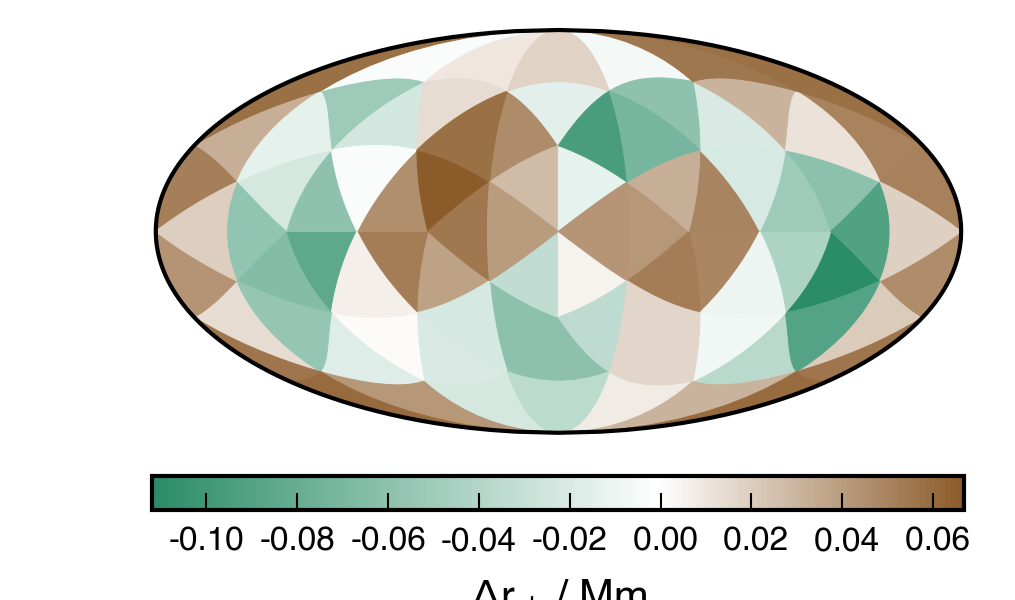

In [51]:
def plot_Mollweide(dump_min, dump_max, r1, r2, output_dir = None, Filename = None, ifig = 2):
    
    '''
    Parameters
    ----------
    dump_min/dump_max = int
        Range of file numbers you want to use in the histogram
    r1/r2 = float
        This function will only search for the convective 
        boundary in the range between r1/r2
    ouput_dir: string
        path to output directory
    filename: string
        name for output file, None: no output
    '''
    
    plt.close(ifig); fig = plt.figure(ifig, figsize = (3.384, 2.))
    fig.patch.set_facecolor('w')
    fig.patch.set_alpha(1.)
    dr_ub_avg = np.zeros(80)

    n = 0
    for dump in range(dump_min, dump_max + 1):
        rp = rp_set.get_dump(dump)
        res = analyse_dump(rp, r1, r2)
        r_ub = res[3]
        dr_ub = r_ub - sum(r_ub)/float(len(r_ub))
        dr_ub_avg += dr_ub
        n += 1

    dr_ub_avg /= float(n)
    if Filename is not None:
        filename = output_dir + Filename
    else:
        filename = None
        
    bucket_map(rp, dr_ub_avg, file_name = filename)

In [ ]:
plot_Mollweide(100,209,7.4,8.4)